In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import catboost
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# reading data, checking nulls, selecting target feature
df = pd.read_csv("/kaggle/input/brain-stroke-dataset/brain_stroke.csv")
print("Check for nulls in columns: ")
print(df.isnull().sum())
target = 'stroke'

Check for nulls in columns: 
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


No nulls to be removed

In [3]:
# checking for dupes
print("Check for duplicate rows: " + str(df.duplicated().sum()))


Check for duplicate rows: 0


Theres no duplicate data to be removed

In [4]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [5]:
# checking for outliers (no action was needed)
# outliers = []

# threshold = 3
# mean = np.mean(df['bmi'])
# std = np.std(df['bmi'])

# for i in df['bmi']:
#     z = (i-mean)/std
#     if np.abs(z) > threshold:
#         outliers.append(i)

# outliers

In [6]:
# Manually Label Encoding <smoking_status>

print(set(df['smoking_status']))
mapping = {'never smoked': 1, 'formerly smoked': 2, 'smokes': 3 , 'Unknown' : 4}
df['encoded_smoking_status'] = df['smoking_status'].map(mapping)

{'smokes', 'formerly smoked', 'never smoked', 'Unknown'}


Manually labelling smoking status in a way to rank smoking status

In [7]:
# Label Encoding <gender,ever_married>

label_encoder = LabelEncoder()
df['encoded_gender'] = label_encoder.fit_transform(df['gender'])
df['encoded_ever_married'] = label_encoder.fit_transform(df['ever_married'])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,encoded_smoking_status,encoded_gender,encoded_ever_married
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,2,1,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1,1,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,3,0,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,1,0,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0,2,1,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0,3,1,1
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0,3,0,1
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0,3,1,1


In [8]:
# Using OneHotEncoder to encode <work_type>

oneHotEncoder = OneHotEncoder()  
encoded_features = oneHotEncoder.fit_transform(df[['work_type']])
encoded_column_names = oneHotEncoder.get_feature_names_out(['work_type'])
df[encoded_column_names] = encoded_features.toarray()
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,encoded_smoking_status,encoded_gender,encoded_ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,2,1,1,0.0,1.0,0.0,0.0
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1,1,1,0.0,1.0,0.0,0.0
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,3,0,1,0.0,1.0,0.0,0.0
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,1,0,1,0.0,0.0,1.0,0.0
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,2,1,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0,2,1,0,0.0,1.0,0.0,0.0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0,3,1,1,0.0,1.0,0.0,0.0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0,3,0,1,1.0,0.0,0.0,0.0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0,3,1,1,0.0,1.0,0.0,0.0


In [9]:
# Using OneHotEncoder to encode <Residence_type>
oneHotEncoder2 = OneHotEncoder()
encoded_features2 = oneHotEncoder2.fit_transform(df[['Residence_type']])
encoded_column_names2 = oneHotEncoder2.get_feature_names_out(['Residence_type'])
df[encoded_column_names2] = encoded_features2.toarray()

df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,encoded_smoking_status,encoded_gender,encoded_ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,2,1,1,0.0,1.0,0.0,0.0,0.0,1.0
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1,1,1,0.0,1.0,0.0,0.0,1.0,0.0
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,3,0,1,0.0,1.0,0.0,0.0,0.0,1.0
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,2,1,1,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0,2,1,0,0.0,1.0,0.0,0.0,1.0,0.0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0,3,1,1,0.0,1.0,0.0,0.0,0.0,1.0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0,3,0,1,1.0,0.0,0.0,0.0,1.0,0.0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0,3,1,1,0.0,1.0,0.0,0.0,1.0,0.0


In [10]:
# Dropping textual features and keeping encoded ones
print(set(df['work_type']))
cols_drop = ['gender','ever_married', 'work_type', 'Residence_type' , 'smoking_status']
# df = df.drop(columns=['gender','ever_married', 'work_type', 'Residence_type' , 'smoking_status'])
df.drop(columns=cols_drop, inplace=True)
df

{'Govt_job', 'Private', 'Self-employed', 'children'}


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,encoded_smoking_status,encoded_gender,encoded_ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban
0,67.0,0,1,228.69,36.6,1,2,1,1,0.0,1.0,0.0,0.0,0.0,1.0
1,80.0,0,1,105.92,32.5,1,1,1,1,0.0,1.0,0.0,0.0,1.0,0.0
2,49.0,0,0,171.23,34.4,1,3,0,1,0.0,1.0,0.0,0.0,0.0,1.0
3,79.0,1,0,174.12,24.0,1,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0
4,81.0,0,0,186.21,29.0,1,2,1,1,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,41.0,0,0,70.15,29.8,0,2,1,0,0.0,1.0,0.0,0.0,1.0,0.0
4977,40.0,0,0,191.15,31.1,0,3,1,1,0.0,1.0,0.0,0.0,0.0,1.0
4978,45.0,1,0,95.02,31.8,0,3,0,1,1.0,0.0,0.0,0.0,1.0,0.0
4979,40.0,0,0,83.94,30.0,0,3,1,1,0.0,1.0,0.0,0.0,1.0,0.0


In [11]:
# dropping target column and scaling data using minmaxscaler
y = df[target]
X = df.drop(columns=[target])

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,age,hypertension,heart_disease,avg_glucose_level,bmi,encoded_smoking_status,encoded_gender,encoded_ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban
0,0.816895,0.0,1.0,0.801265,0.647564,0.333333,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.975586,0.0,1.0,0.234512,0.530086,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.597168,0.0,0.0,0.536008,0.584527,0.666667,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.963379,1.0,0.0,0.549349,0.286533,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.987793,0.0,0.0,0.605161,0.429799,0.333333,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,0.499512,0.0,0.0,0.069384,0.452722,0.333333,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4977,0.487305,0.0,0.0,0.627966,0.489971,0.666667,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4978,0.548340,1.0,0.0,0.184194,0.510029,0.666667,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4979,0.487305,0.0,0.0,0.133044,0.458453,0.666667,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


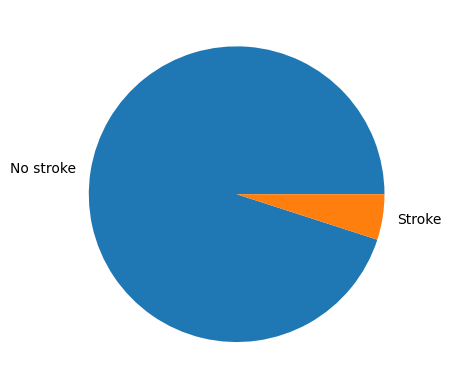

In [12]:
# pie chart for target feature
vals = y.value_counts()
mylabels = ['No stroke', 'Stroke']
plt.pie(vals, labels = mylabels)
plt.show() 

As we can see here the 'stroke' feature is mostly made out of zeros and only a few ones. This causes an issue called "Target Class Imbalance", this results in the model predicting the common class more than the target class.
One of the solutions to balance the classes is to undersample the zeros to have the same number of datapoints as the ones. It works by reducing random samples from the zero class, aka, the "No Stroke" class.  

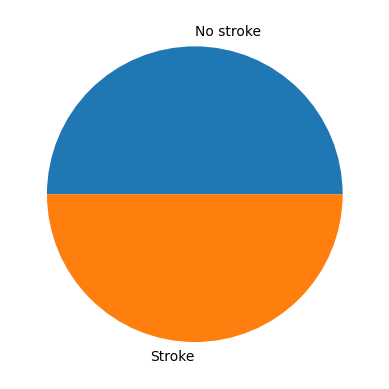

In [13]:
# Undersampling and splitting data
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.25, random_state=52)


y_under.value_counts()

# pie chart for target feature
vals = y_under.value_counts()
mylabels = ['No stroke', 'Stroke']
plt.pie(vals, labels = mylabels)
plt.show() 

In [14]:
# print('### BEFORE UNDER SAMPLING ###')
print('### y_train SAMPLING ###')
print(f"Training data points:\n {y_under.value_counts()}")

# print('\n### AFTER UNDER SAMPLING ###')
print('### y_test SAMPLING ###')
print(f"Training data points:\n {y_test.value_counts()}")

### y_train SAMPLING ###
Training data points:
 stroke
0    248
1    248
Name: count, dtype: int64
### y_test SAMPLING ###
Training data points:
 stroke
0    64
1    60
Name: count, dtype: int64


As you can see the number of 0 datapoints is reduced to be the same number as the 1 datapoints

In [15]:
# defining models
xgb_clf = xgb.XGBClassifier(n_estimators = 2000)
cat_clf = catboost.CatBoostClassifier(verbose=0, iterations = 2000)
lgr_clf = LogisticRegression()

# Fitting models
xgb_clf.fit(X_under, y_under)
cat_clf.fit(X_under, y_under)
lgr_clf.fit(X_under, y_under)

LogisticRegression()

In [16]:
# predicting test data
xgb_pred = xgb_clf.predict(X_test)
cat_pred = cat_clf.predict(X_test)
lgr_pred = lgr_clf.predict(X_test)

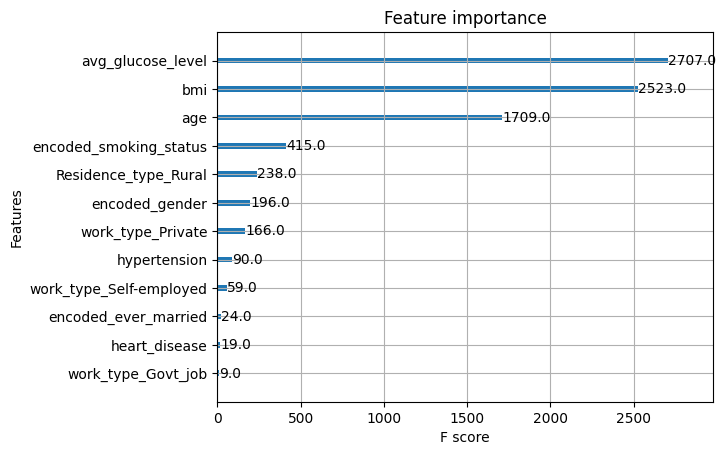

In [17]:
# XGB feature importance
xgb.plot_importance(xgb_clf)
plt.show()

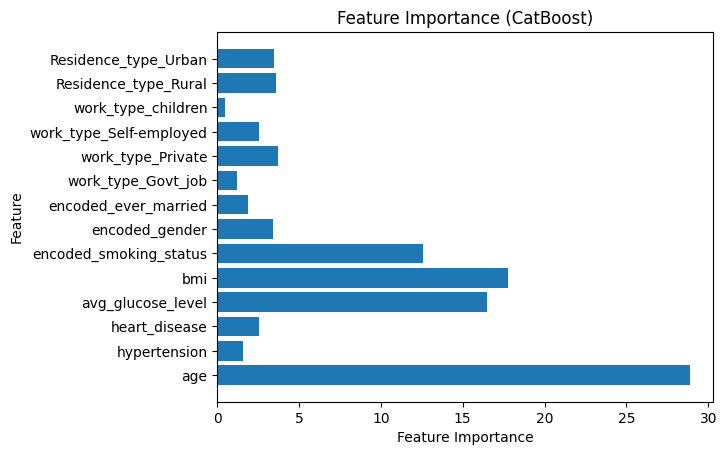

In [18]:
# Catboost feature importance
feature_importance = cat_clf.get_feature_importance(type='FeatureImportance')
feature_names = X_train.columns

plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (CatBoost)')
plt.show()

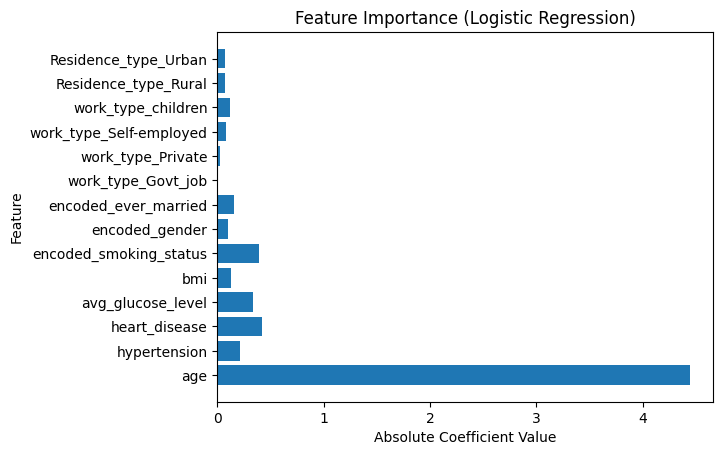

In [19]:
# Logistic Regression feature importance
feature_importance = np.abs(lgr_clf.coef_[0])
feature_names = X_train.columns

plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

As you can see all 3 models have different feature prioroties to base their prediction off
I have tested out ensembling all 3 models which resulted in better accuracy since there is a variety in feature importance to each model and through some weight testing it was best to give XGBoost 50% of the weight and 25% for each of CatBoost and LogisticRegression models

In [31]:
# ensembling multiple models (XGBoost/CatBoost/LogisticRegression)
ensemble = (xgb_pred + cat_pred + lgr_pred) / 3
ensemble = list(map(round , ensemble))
unique_values, counts = np.unique(ensemble, return_counts=True)

In [36]:
# F1 scoring metric
f1_score(y_test, ensemble)

0.9836065573770492

# F1 Score

Through some research the F1 scoring metric was the most fit scoring metric since it takes the best properties of both precision metric and recall metric

precision metric: evaluates the model's ability to correctly guess the stroke status when it is actually true 

recall metric: evaluates the model's ability to not miss any of the true stroke status

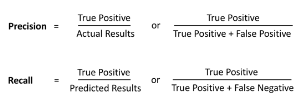

# Findings

* Through some research outliers in this dataset werent faulty data, however they are real data for real rare cases which are really important for the model to use them to train so they should NOT be removed, especially when its related to medical predictions

* The dataset is very imbalanced in favor to 'no stroke' than 'stroke' so as a solution to solve this problem for the model to train properly undersampling was used

---------score before undersampling: 0.7761194029850748

---------score after undersampling: 0.9836065573770492

* It was more ideal to use the 3 models (XGBoost, CatBoost, Logistic Regression) because they provided more variety in feature importance, the understanding of the ensembled model will be more generalized moreover it will decrease the chances for overfitting